In [35]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from climada.util.constants import SYSTEM_DIR

# --- CONFIG ---
model = "CESM2"
scenario = "ssp245"
period = "base"
rp_key = "rp_100"
region_bounds = {
    "Caribbean": [-100, -40, 5, 40],
    "Southeast Asia": [90, 150, 5, 30],
    "Global": [-180, 180, -90, 90]
}
selected_region = "Global"

# --- PATHS ---
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"
netcdf_path = haz_dir / f"TC_global_0300as_CHAZ_{model}_{period}_{scenario}_80ens_CRH_H08_exceedance_intensity.nc"

# --- LOAD LAND SHAPE ---
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")

# --- LOAD DATA ---
ds = xr.open_dataset(netcdf_path)
lat = ds["lat"].values
lon = ds["lon"].values
values = ds[rp_key].values

# --- CREATE GEODATAFRAME ---
df = pd.DataFrame({"lat": lat, "lon": lon, "value": values})
df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# --- CLIP TO LAND ---
gdf = gpd.clip(gdf, land)

# --- FILTER TO REGION ---
min_lon, max_lon, min_lat, max_lat = region_bounds[selected_region]
gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]


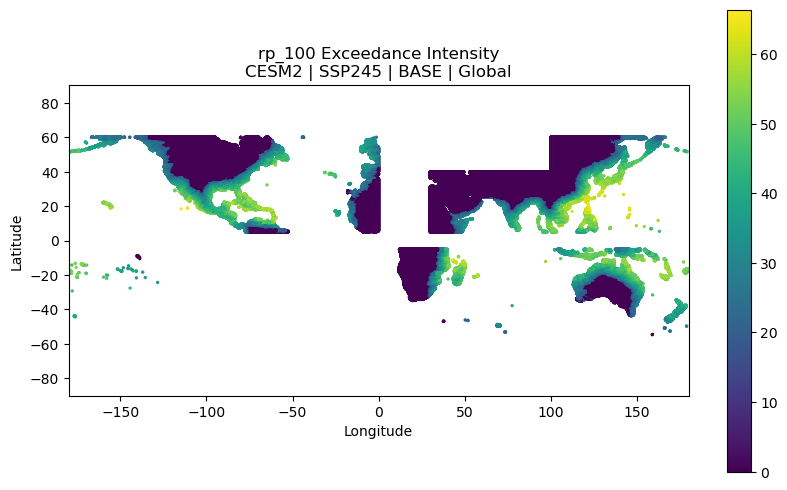

In [36]:
# --- PLOT ---
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(column="value", cmap="viridis", markersize=2, ax=ax, legend=True)
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.set_title(f"{rp_key} Exceedance Intensity\n{model} | {scenario.upper()} | {period.upper()} | {selected_region}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

/Users/simonameiler/miniforge3/envs/climada_env/lib/python3.11/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


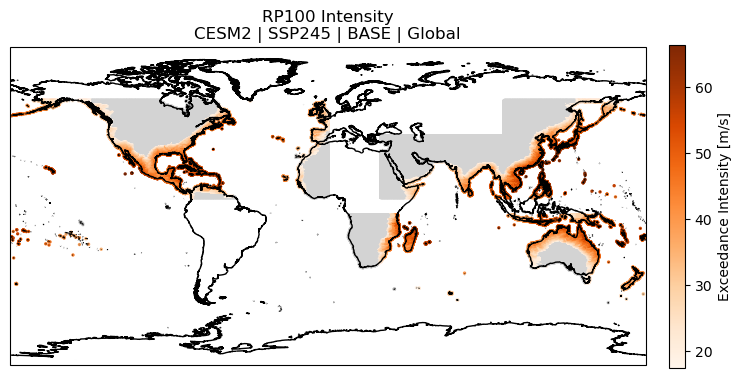

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import numpy as np

# Choose map type
is_rp_map = False  # set False for intensity

# Choose colormap
cmap_name = "Blues" if is_rp_map else "Oranges"
cmap = plt.get_cmap(cmap_name).copy()
cmap.set_bad("lightgrey")  # grey for masked areas (like zero)

# Mask 0 or NaN values
masked_vals = np.ma.masked_where((gdf["value"] <= 0) | (gdf["value"].isna()), gdf["value"])

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

sc = ax.scatter(
    gdf["lon"], gdf["lat"], c=masked_vals,
    cmap=cmap, s=2, transform=ccrs.PlateCarree()
)

ax.coastlines(resolution='10m')
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.03)
cbar.set_label("Return Period [years]" if is_rp_map else "Exceedance Intensity [m/s]")

title_type = "Return Period" if is_rp_map else "RP100 Intensity"
ax.set_title(f"{title_type}\n{model} | {scenario.upper()} | {period.upper()} | {selected_region}")
plt.show()


## Return period maps of Cat. 1 TCs

In [32]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Point
from climada.util.constants import SYSTEM_DIR

# --- CONFIG ---
models = [
    "CESM2", "CNRM-CM6-1", "EC-Earth3", "IPSL-CM6A-LR",
    "MIROC6", "MPI-ESM1-2-HR", "UKESM1-0-LL"
]
scenarios = ["ssp245", "ssp370", "ssp585"]
periods = ["base", "fut1", "fut2"]
tcgi = "CRH"
threshold = 33
rp_key = f"thr_{threshold}"
region_bounds = {
    "Caribbean": [-100, -40, 5, 40],
    "Southeast Asia": [90, 150, 5, 30],
    "Global": [-180, 180, -90, 90]
}
selected_region = "Southeast Asia"
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")
min_lon, max_lon, min_lat, max_lat = region_bounds[selected_region]


Compute multi-model medians

In [33]:
# Store median GeoDataFrames per period/scenario
median_maps = {}

for period in periods:
    for scenario in scenarios:
        all_model_vals = []

        for model in models:
            file = f"TC_global_0300as_CHAZ_{model}_{period}_{scenario}_80ens_{tcgi}_H08_return_periods.nc"
            path = haz_dir / file
            if not path.exists():
                continue

            try:
                ds = xr.open_dataset(path)
                if rp_key not in ds:
                    continue

                df = pd.DataFrame({
                    "lat": ds["lat"].values,
                    "lon": ds["lon"].values,
                    rp_key: ds[rp_key].values
                })
                df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
                gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

                gdf = gpd.clip(gdf, land)
                gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

                if not gdf.empty:
                    gdf = gdf.set_index(["lat", "lon"])
                    all_model_vals.append(gdf[rp_key])

            except Exception as e:
                print(f"Error loading {file}: {e}")

        if all_model_vals:
            merged = pd.concat(all_model_vals, axis=1)
            median_vals = merged.median(axis=1).reset_index()
            median_vals.rename(columns={0: rp_key}, inplace=True)
            median_vals["geometry"] = [Point(xy) for xy in zip(median_vals.lon, median_vals.lat)]
            gdf_median = gpd.GeoDataFrame(median_vals, geometry="geometry", crs="EPSG:4326")
            median_maps[(period, scenario)] = gdf_median


Plot single map

Plot all subplots over scenarios and future periods

/var/folders/7j/w3ygw9_d0wb9dn7w0f21n_980000gn/T/ipykernel_84278/3001029830.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.12, 1, 1])


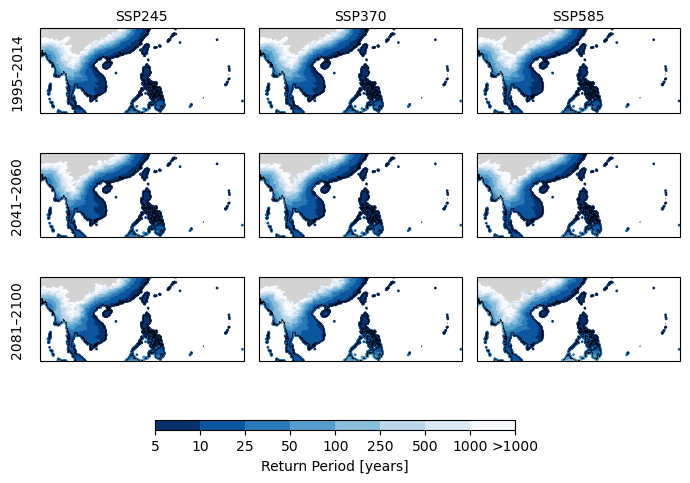

In [24]:
import matplotlib.colors as mcolors
from pathlib import Path

# --- Bin settings ---
bins = [5, 10, 25, 50, 100, 250, 500, 1000, 10000]
log_bins = np.log10(bins)
tick_labels = [str(b) for b in bins[:-1]] + [">1000"]
norm = mcolors.BoundaryNorm(log_bins, ncolors=len(bins) - 1)
cmap = plt.get_cmap("Blues_r", len(bins) - 1)
cmap.set_bad("lightgrey")

# --- Period labels ---
period_labels = {
    "base": "1995–2014",
    "fut1": "2041–2060",
    "fut2": "2081–2100"
}
fontsize = 10

# --- Plot ---
fig, axes = plt.subplots(3, 3, figsize=(7.2, 4.8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(wspace=0.05, hspace=0.15)

scatter_ref = None

for i, period in enumerate(periods):
    for j, scenario in enumerate(scenarios):
        ax = axes[i, j]
        gdf = median_maps.get((period, scenario))

        if gdf is not None:
            log_vals = np.log10(gdf[rp_key])
            masked_vals = np.ma.masked_where((log_vals <= 0) | (log_vals.isna()), log_vals)

            sc = ax.scatter(
                gdf["lon"], gdf["lat"], c=masked_vals,
                cmap=cmap, s=1, transform=ccrs.PlateCarree(), norm=norm
            )
            if scatter_ref is None:
                scatter_ref = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Colorbar ---
if scatter_ref is not None:
    cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.02])
    cbar = fig.colorbar(scatter_ref, cax=cbar_ax, orientation='horizontal', ticks=log_bins)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.set_label("Return Period [years]", fontsize=fontsize)
else:
    print("⚠️ No valid data to plot — skipping colorbar.")

plt.tight_layout(rect=[0.03, 0.12, 1, 1])
plt.show()

# --- Optional: Save the figure ---
save_fig = True  # Set to False to skip saving

if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_map_3x3_thr{threshold}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')


#### Difference plots

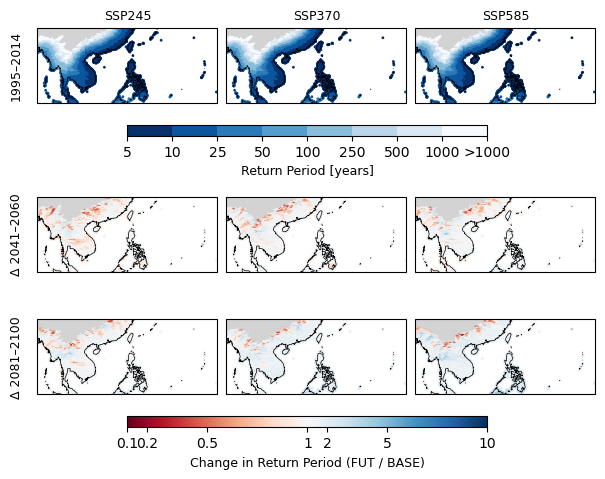

✅ Saved: /Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_ratio_thr_33_SD.png


In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path

# --- Setup ---
fontsize = 9
fig = plt.figure(figsize=(7.2, 5.2))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 0.3, 1, 1], wspace=0.05, hspace=0.15)

# RP absolute color settings (baseline RP)
bins = [5, 10, 25, 50, 100, 250, 500, 1000, 10000]
log_bins = np.log10(bins)
tick_labels = [str(b) for b in bins[:-1]] + [">1000"]
norm_abs = mcolors.BoundaryNorm(log_bins, ncolors=len(bins) - 1)
cmap_abs = plt.get_cmap("Blues_r", len(bins) - 1)
cmap_abs.set_bad("lightgrey")

# RP ratio color settings (FUT / BASE)
cmap_diff = plt.get_cmap("RdBu").copy()
cmap_diff.set_bad("lightgrey")
norm_diff = mcolors.TwoSlopeNorm(vmin=0.1, vcenter=1, vmax=10)

# Periods and labels
periods = ["base", "fut1", "fut2"]
period_labels = {
    "base": "1995–2014",
    "fut1": "Δ 2041–2060",
    "fut2": "Δ 2081–2100"
}

scatter_refs = {"abs": None, "diff": None}

for i, period in enumerate(periods):
    for j, scenario in enumerate(scenarios):
        row_idx = i if i == 0 else i + 1  # spacer row at index 1
        ax = fig.add_subplot(gs[row_idx, j], projection=ccrs.PlateCarree())

        gdf = median_maps.get((period, scenario))
        gdf_base = median_maps.get(("base", scenario)) if period != "base" else None

        if gdf is not None:
            if period == "base":
                log_vals = np.log10(gdf[rp_key])
                masked_vals = np.ma.masked_where((log_vals <= 0) | (log_vals.isna()), log_vals)

                sc = ax.scatter(
                    gdf["lon"], gdf["lat"], c=masked_vals,
                    cmap=cmap_abs, s=1, transform=ccrs.PlateCarree(), norm=norm_abs
                )
                if scatter_refs["abs"] is None:
                    scatter_refs["abs"] = sc
            elif gdf_base is not None:
                # Compute FUT / BASE ratio
                df_merged = gdf.set_index(["lat", "lon"]).join(
                    gdf_base.set_index(["lat", "lon"]),
                    lsuffix="_fut", rsuffix="_base"
                )
                val_fut = df_merged[f"{rp_key}_fut"]
                val_base = df_merged[f"{rp_key}_base"]
                ratio = val_fut / val_base
                ratio = ratio.clip(lower=0.1, upper=10)
                masked_vals = np.ma.masked_where(ratio.isna(), ratio)

                coords = df_merged.index.to_frame(index=False)

                sc = ax.scatter(
                    coords["lon"], coords["lat"], c=masked_vals,
                    cmap=cmap_diff, norm=norm_diff,
                    s=2, transform=ccrs.PlateCarree()
                )
                if scatter_refs["diff"] is None:
                    scatter_refs["diff"] = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Colorbars ---
if scatter_refs["abs"] is not None:
    cbar_ax_abs = fig.add_axes([0.25, 0.64, 0.5, 0.02])
    cbar = fig.colorbar(scatter_refs["abs"], cax=cbar_ax_abs, orientation='horizontal', ticks=log_bins)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.set_label("Return Period [years]", fontsize=fontsize)

if scatter_refs["diff"] is not None:
    cbar_ax_diff = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_diff, orientation='horizontal')
    cbar_diff.set_ticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
    cbar_diff.set_ticklabels(["0.1", "0.2", "0.5", "1", "2", "5", "10"])
    cbar_diff.set_label("Change in Return Period (FUT / BASE)", fontsize=fontsize)

plt.show()

# --- Save ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_ratio_{rp_key}_{tcgi}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_path}")


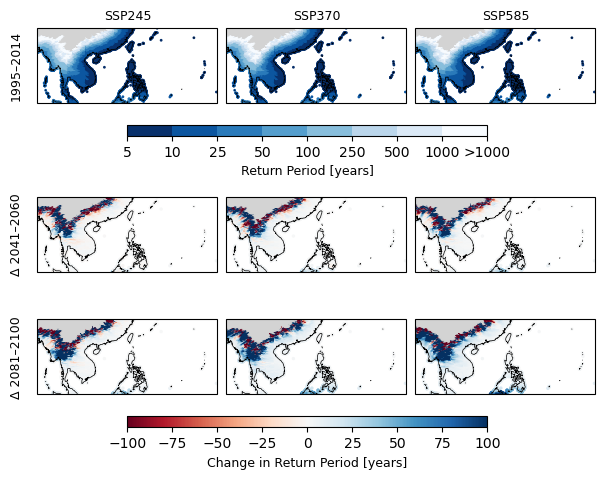

✅ Saved: /Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_diff_abs_thr_33_SD.png


In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path

# --- Setup ---
fontsize = 9
fig = plt.figure(figsize=(7.2, 5.2))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 0.3, 1, 1], wspace=0.05, hspace=0.15)

# RP absolute color settings (baseline RP)
bins = [5, 10, 25, 50, 100, 250, 500, 1000, 10000]
log_bins = np.log10(bins)
tick_labels = [str(b) for b in bins[:-1]] + [">1000"]
norm_abs = mcolors.BoundaryNorm(log_bins, ncolors=len(bins) - 1)
cmap_abs = plt.get_cmap("Blues_r", len(bins) - 1)
cmap_abs.set_bad("lightgrey")

# RP ratio color settings (FUT / BASE)
cmap_diff = plt.get_cmap("RdBu").copy()
cmap_diff.set_bad("lightgrey")
norm_diff = mcolors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)

# Periods and labels
periods = ["base", "fut1", "fut2"]
period_labels = {
    "base": "1995–2014",
    "fut1": "Δ 2041–2060",
    "fut2": "Δ 2081–2100"
}

scatter_refs = {"abs": None, "diff": None}

for i, period in enumerate(periods):
    for j, scenario in enumerate(scenarios):
        row_idx = i if i == 0 else i + 1  # spacer row at index 1
        ax = fig.add_subplot(gs[row_idx, j], projection=ccrs.PlateCarree())

        gdf = median_maps.get((period, scenario))
        gdf_base = median_maps.get(("base", scenario)) if period != "base" else None

        if gdf is not None:
            if period == "base":
                log_vals = np.log10(gdf[rp_key])
                masked_vals = np.ma.masked_where((log_vals <= 0) | (log_vals.isna()), log_vals)

                sc = ax.scatter(
                    gdf["lon"], gdf["lat"], c=masked_vals,
                    cmap=cmap_abs, s=1, transform=ccrs.PlateCarree(), norm=norm_abs
                )
                if scatter_refs["abs"] is None:
                    scatter_refs["abs"] = sc
            elif gdf_base is not None:
                # Compute FUT / BASE ratio
                df_merged = gdf.set_index(["lat", "lon"]).join(
                    gdf_base.set_index(["lat", "lon"]),
                    lsuffix="_fut", rsuffix="_base"
                )
                val_fut = df_merged[f"{rp_key}_fut"]
                val_base = df_merged[f"{rp_key}_base"]
                diff = val_fut - val_base
                masked_vals = np.ma.masked_where(diff.isna(), diff)

                coords = df_merged.index.to_frame(index=False)

                sc = ax.scatter(
                    coords["lon"], coords["lat"], c=masked_vals,
                    cmap=cmap_diff, norm=norm_diff,
                    s=2, transform=ccrs.PlateCarree()
                )
                if scatter_refs["diff"] is None:
                    scatter_refs["diff"] = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Colorbars ---
if scatter_refs["abs"] is not None:
    cbar_ax_abs = fig.add_axes([0.25, 0.64, 0.5, 0.02])
    cbar = fig.colorbar(scatter_refs["abs"], cax=cbar_ax_abs, orientation='horizontal', ticks=log_bins)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.set_label("Return Period [years]", fontsize=fontsize)

if scatter_refs["diff"] is not None:
    cbar_ax_diff = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_diff, orientation='horizontal')
    #cbar_diff.set_ticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
    #cbar_diff.set_ticklabels(["0.1", "0.2", "0.5", "1", "2", "5", "10"])
    cbar_diff.set_label("Change in Return Period [years]", fontsize=fontsize)

plt.show()

# --- Save ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_diff_abs_{rp_key}_{tcgi}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_path}")


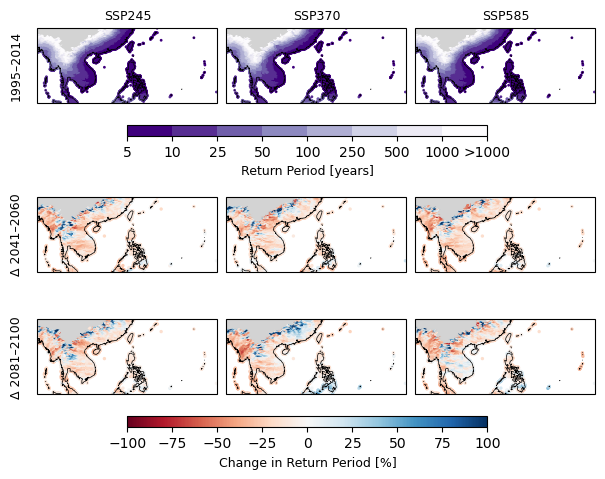

✅ Saved: /Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_diff_pct_thr_33_CRH_Southeast Asia.png


In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path

# --- Setup ---
fontsize = 9
fig = plt.figure(figsize=(7.2, 5.2))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 0.3, 1, 1], wspace=0.05, hspace=0.15)

# RP settings
bins = [5, 10, 25, 50, 100, 250, 500, 1000, 10000]
log_bins = np.log10(bins)
tick_labels = [str(b) for b in bins[:-1]] + [">1000"]
norm = mcolors.BoundaryNorm(log_bins, ncolors=len(bins) - 1)
cmap_abs = plt.get_cmap("Purples_r", len(bins) - 1)
cmap_abs.set_bad("lightgrey")

# % diff colorbar
cmap_diff = plt.get_cmap("RdBu").copy()
cmap_diff.set_bad("lightgrey")
vmin_pct, vmax_pct = -100, 100  # clip percent changes

periods = ["base", "fut1", "fut2"]
period_labels = {
    "base": "1995–2014",
    "fut1": "Δ 2041–2060",
    "fut2": "Δ 2081–2100"
}

scatter_refs = {"abs": None, "diff": None}

for i, period in enumerate(periods):
    for j, scenario in enumerate(scenarios):
        row_idx = i if i == 0 else i + 1  # adjust for spacer
        ax = fig.add_subplot(gs[row_idx, j], projection=ccrs.PlateCarree())

        gdf = median_maps.get((period, scenario))
        gdf_base = median_maps.get(("base", scenario)) if period != "base" else None

        if gdf is not None:
            if period == "base":
                log_vals = np.log10(gdf[rp_key])
                masked_vals = np.ma.masked_where((log_vals <= 0) | (log_vals.isna()), log_vals)

                sc = ax.scatter(
                    gdf["lon"], gdf["lat"], c=masked_vals,
                    cmap=cmap_abs, s=1, transform=ccrs.PlateCarree(), norm=norm
                )
                if scatter_refs["abs"] is None:
                    scatter_refs["abs"] = sc
            elif gdf_base is not None:
                df_merged = gdf.set_index(["lat", "lon"]).join(
                    gdf_base.set_index(["lat", "lon"]),
                    lsuffix="_fut", rsuffix="_base"
                )
                base_vals = df_merged[f"{rp_key}_base"]
                fut_vals = df_merged[f"{rp_key}_fut"]

                pct_change = ((fut_vals - base_vals) / base_vals) * 100
                pct_change = pct_change.clip(lower=vmin_pct, upper=vmax_pct)
                masked_vals = np.ma.masked_where(pct_change.isna(), pct_change)

                coords = df_merged.index.to_frame(index=False)
                sc = ax.scatter(
                    coords["lon"], coords["lat"], c=masked_vals,
                    cmap=cmap_diff, vmin=vmin_pct, vmax=vmax_pct,
                    s=2, transform=ccrs.PlateCarree()
                )
                if scatter_refs["diff"] is None:
                    scatter_refs["diff"] = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Colorbars ---
if scatter_refs["abs"] is not None:
    cbar_ax_abs = fig.add_axes([0.25, 0.64, 0.5, 0.02])
    cbar = fig.colorbar(scatter_refs["abs"], cax=cbar_ax_abs, orientation='horizontal', ticks=log_bins)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.set_label("Return Period [years]", fontsize=fontsize)

if scatter_refs["diff"] is not None:
    cbar_ax_diff = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_diff, orientation='horizontal')
    cbar_diff.set_label("Change in Return Period [%]", fontsize=fontsize)

plt.show()

# --- Save option ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/rp_diff_pct_{rp_key}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_path}")


## Exceedance intensity maps for RP100

In [10]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from climada.util.constants import SYSTEM_DIR

# --- CONFIG ---
models = [
    "CESM2", "CNRM-CM6-1", "EC-Earth3", "IPSL-CM6A-LR",
    "MIROC6", "MPI-ESM1-2-HR", "UKESM1-0-LL"
]
scenarios = ["ssp245", "ssp370", "ssp585"]
periods = ["base", "fut1", "fut2"]
tcgi = "SD"
rp_key = "rp_100"
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"
region_bounds = {
    "Caribbean": [-100, -40, 5, 40],
    "Southeast Asia": [90, 150, 5, 30],
    "Global": [-180, 180, -90, 90]
}
selected_region = "Southeast Asia"
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")
min_lon, max_lon, min_lat, max_lat = region_bounds[selected_region]

In [11]:
median_maps_intensity = {}

for period in periods:
    for scenario in scenarios:
        all_model_vals = []

        for model in models:
            file = f"TC_global_0300as_CHAZ_{model}_{period}_{scenario}_80ens_{tcgi}_H08_exceedance_intensity.nc"
            path = haz_dir / file
            if not path.exists():
                continue

            try:
                ds = xr.open_dataset(path)
                if rp_key not in ds:
                    continue

                df = pd.DataFrame({
                    "lat": ds["lat"].values,
                    "lon": ds["lon"].values,
                    rp_key: ds[rp_key].values
                })
                df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
                gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

                gdf = gpd.clip(gdf, land)
                gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

                if not gdf.empty:
                    gdf = gdf.set_index(["lat", "lon"])
                    all_model_vals.append(gdf[rp_key])

            except Exception as e:
                print(f"Error loading {file}: {e}")

        if all_model_vals:
            merged = pd.concat(all_model_vals, axis=1)
            median_vals = merged.median(axis=1).reset_index()
            median_vals.rename(columns={0: rp_key}, inplace=True)
            median_vals["geometry"] = [Point(xy) for xy in zip(median_vals.lon, median_vals.lat)]
            gdf_median = gpd.GeoDataFrame(median_vals, geometry="geometry", crs="EPSG:4326")
            median_maps_intensity[(period, scenario)] = gdf_median


Plot single map

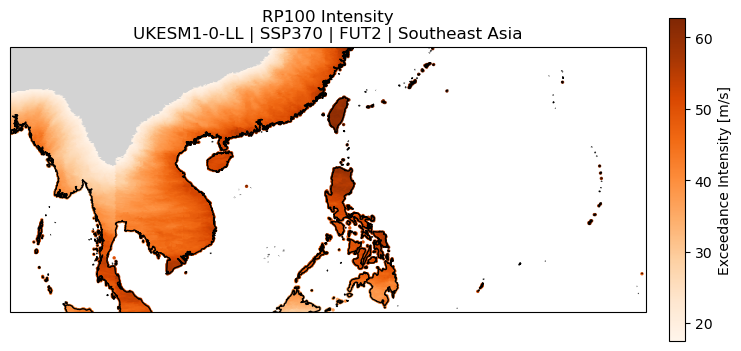

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

# Choose an example to visualize
period = "fut2"
scenario = "ssp370"
gdf = median_maps_intensity[(period, scenario)]

# --- Plot setup ---
cmap = plt.get_cmap("Oranges").copy()
cmap.set_bad("lightgrey")

# Mask 0/NaN
masked_vals = np.ma.masked_where((gdf[rp_key] <= 0) | (gdf[rp_key].isna()), gdf[rp_key])

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
sc = ax.scatter(
    gdf["lon"], gdf["lat"], c=masked_vals,
    cmap=cmap, s=2, transform=ccrs.PlateCarree()
)

ax.coastlines(resolution='10m')
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.03)
cbar.set_label("Return Period [years]" if is_rp_map else "Exceedance Intensity [m/s]")

title_type = "Return Period" if is_rp_map else "RP100 Intensity"
ax.set_title(f"{title_type}\n{model} | {scenario.upper()} | {period.upper()} | {selected_region}")
plt.show()


Plot all subplots over scenarios and future periods

/var/folders/7j/w3ygw9_d0wb9dn7w0f21n_980000gn/T/ipykernel_36005/3916953438.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.12, 1, 1])


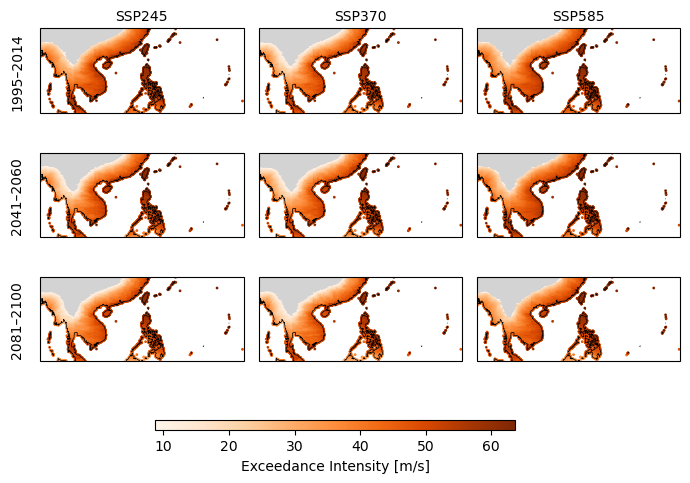

In [13]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# --- Style ---
fontsize = 10
cmap = plt.get_cmap("Oranges").copy()
cmap.set_bad("lightgrey")

# --- Period label mapping ---
period_labels = {
    "base": "1995–2014",
    "fut1": "2041–2060",
    "fut2": "2081–2100"
}

# --- Figure ---
fig, axes = plt.subplots(3, 3, figsize=(7.2, 4.8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(wspace=0.05, hspace=0.15)

scatter_ref = None

for i, period in enumerate(periods):
    for j, scenario in enumerate(scenarios):
        ax = axes[i, j]
        gdf = median_maps_intensity.get((period, scenario))

        if gdf is not None:
            masked_vals = np.ma.masked_where((gdf[rp_key] <= 0) | (gdf[rp_key].isna()), gdf[rp_key])

            sc = ax.scatter(
                gdf["lon"], gdf["lat"], c=masked_vals,
                cmap=cmap, s=1, transform=ccrs.PlateCarree()
            )
            if scatter_ref is None:
                scatter_ref = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        # Column titles (scenarios)
        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        # Row labels (periods)
        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Shared colorbar below ---
if scatter_ref is not None:
    cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.02])
    cbar = fig.colorbar(scatter_ref, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("Exceedance Intensity [m/s]", fontsize=fontsize)
else:
    print("⚠️ No valid data to plot — skipping colorbar.")

plt.tight_layout(rect=[0.03, 0.12, 1, 1])
plt.show()

# --- Save to file ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/exceedance_intensity_{rp_key}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')


#### Difference plots

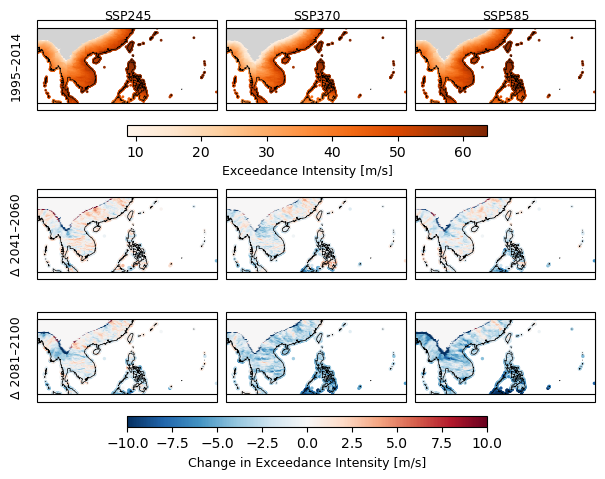

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np

# --- Styling and layout ---
fontsize = 9
fig = plt.figure(figsize=(7.2, 5.2))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[1, 0.3, 1, 1], wspace=0.05, hspace=0.15)

period_rows = ["base", "fut1", "fut2"]
period_labels = {
    "base": "1995–2014",
    "fut1": "Δ 2041–2060",
    "fut2": "Δ 2081–2100"
}

# Colormaps
cmap_abs = plt.get_cmap("Oranges").copy()
cmap_abs.set_bad("lightgrey")
cmap_diff = plt.get_cmap("RdBu_r").copy()
cmap_diff.set_bad("lightgrey")
vmin_diff, vmax_diff = -10, 10

scatter_refs = {"abs": None, "diff": None}

for i, period in enumerate(["base", "fut1", "fut2"]):
    for j, scenario in enumerate(scenarios):
        # Compute the correct row index in GridSpec
        row_idx = i if i == 0 else i + 1  # i=1 (fut1) → row 2, i=2 (fut2) → row 3
        ax = fig.add_subplot(gs[row_idx, j], projection=ccrs.PlateCarree())


        # Adjust row index in GridSpec: row 0 → base, 2 → fut1, 3 → fut2
        row_idx = i if i == 0 else i + 1
        ax = fig.add_subplot(gs[row_idx, j], projection=ccrs.PlateCarree())

        gdf = median_maps_intensity.get((period, scenario))
        gdf_base = median_maps_intensity.get(("base", scenario)) if period != "base" else None

        if gdf is not None:
            if period == "base":
                masked_vals = np.ma.masked_where((gdf[rp_key] <= 0) | (gdf[rp_key].isna()), gdf[rp_key])
                sc = ax.scatter(
                    gdf["lon"], gdf["lat"], c=masked_vals,
                    cmap=cmap_abs, s=1, transform=ccrs.PlateCarree()
                )
                if scatter_refs["abs"] is None:
                    scatter_refs["abs"] = sc
            else:
                df_merged = gdf.set_index(["lat", "lon"]).join(
                    gdf_base.set_index(["lat", "lon"]),
                    lsuffix="_fut", rsuffix="_base"
                )
                diff_vals = df_merged[f"{rp_key}_fut"] - df_merged[f"{rp_key}_base"]
                masked_vals = np.ma.masked_where(diff_vals.isna(), diff_vals)

                coords = df_merged.index.to_frame(index=False)
                sc = ax.scatter(
                    coords["lon"], coords["lat"], c=masked_vals,
                    cmap=cmap_diff, vmin=vmin_diff, vmax=vmax_diff,
                    s=2, transform=ccrs.PlateCarree()
                )
                if scatter_refs["diff"] is None:
                    scatter_refs["diff"] = sc

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)

        if i == 0:
            ax.set_title(scenario.upper(), fontsize=fontsize)

        if j == 0:
            ax.text(
                -0.08, 0.5, period_labels[period],
                transform=ax.transAxes, rotation=90,
                fontsize=fontsize, va='center', ha='right'
            )

# --- Colorbars ---
if scatter_refs["abs"] is not None:
    cbar_ax_abs = fig.add_axes([0.25, 0.64, 0.5, 0.02])
    cbar = fig.colorbar(scatter_refs["abs"], cax=cbar_ax_abs, orientation='horizontal')
    cbar.set_label("Exceedance Intensity [m/s]", fontsize=fontsize)

if scatter_refs["diff"] is not None:
    cbar_ax_diff = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    cbar_diff = fig.colorbar(scatter_refs["diff"], cax=cbar_ax_diff, orientation='horizontal')
    cbar_diff.set_label("Change in Exceedance Intensity [m/s]", fontsize=fontsize)

#plt.tight_layout(rect=[0.03, 0.14, 1, 0.95])
plt.show()

# --- Save to file ---
save_fig = True
if save_fig:
    output_path = Path(f"/Users/simonameiler/Documents/work/03_code/repos/CHAZ-hazard-maps/CHAZ-hazard-maps/figures/exceedance_intensity_diff_{rp_key}_{tcgi}_{selected_region}.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')



### Baseline checks

In [ ]:
# ─── 1. Imports & Data-loading ─────────────────────────────────────────────────

import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray as rxr
import numpy as np
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point
from climada.util.constants import SYSTEM_DIR

# --- PATHS ---
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"

var = "exceedance_intensity"
var_key = "rp_100"
ssps = ["ssp245", "ssp370", "ssp585"]
tcgis = ["SD", "CRH"]

# --- LOAD LAND SHAPE ---
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")

def load_and_clip_gdf(netcdf_path, land):
    """Load a NetCDF file and clip it to the land shape."""
    ds = xr.open_dataset(netcdf_path)
    lat = ds["lat"].values
    lon = ds["lon"].values
    values = ds[var_key].values

    df = pd.DataFrame({"lat": lat, "lon": lon, "value": values})
    df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

    return gpd.clip(gdf, land)

# --- LOAD ERA5 DATA ---
era5_path = haz_dir / f"TC_100.0_180.0_5.0_60.0_0300as_CHAZ_ERA5_{var}.nc"
era5_gdf = load_and_clip_gdf(era5_path, land)

# --- LOAD BASELINE GCM DATA ---
baseline_gdfs = {}
for ssp in ssps:
    for tcgi in tcgis:
        netcdf_path = haz_dir / f"TC_100.0_180.0_5.0_60.0_0300as_CHAZ_ALL-MODELS_base_{ssp}_480ens_{tcgi}_H08_{var}.nc"
        baseline_gdfs[(ssp, tcgi)] = load_and_clip_gdf(netcdf_path, land)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/simonameiler/climada/data/hazard/future/CHAZ_update/maps/TC_100.0_180.0_5.0_60.0_0300as_CHAZ_ALL-MODELS_base_ssp245_480ens_CRH_H08_exceedance_intensity.nc'

### Comparison to STORM

In [81]:
# ─── 1. Imports & Data-loading ─────────────────────────────────────────────────

import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray as rxr
import numpy as np
from sklearn.metrics import mean_squared_error
from shapely.geometry import Point
from climada.util.constants import SYSTEM_DIR

# --- PATHS ---
haz_dir = SYSTEM_DIR / "hazard" / "future" / "CHAZ_update" / "maps"
shapefile_path = SYSTEM_DIR / "ne_10m_land" / "ne_10m_land.shp"
netcdf_path = haz_dir / f"TC_100.0_180.0_5.0_60.0_0300as_CHAZ_ERA5_exceedance_intensity.nc"


var_key = "rp_100"

# --- LOAD LAND SHAPE ---
land = gpd.read_file(shapefile_path).to_crs("EPSG:4326")

# --- LOAD DATA ---
ds = xr.open_dataset(netcdf_path)
lat = ds["lat"].values
lon = ds["lon"].values
values = ds[var_key].values

# --- CREATE GEODATAFRAME ---
df = pd.DataFrame({"lat": lat, "lon": lon, "value": values})
df["geometry"] = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# --- CLIP TO LAND ---
gdf = gpd.clip(gdf, land)


In [84]:
storm_path = "data/STORM_FIXED_RETURN_PERIODS_PRESENT_TIF/STORM_FIXED_RETURN_PERIODS_WP_100_YR_RP.tif"
# 1.2 Load STORM reference GeoTIF (e.g. 50 yr return period)
ds_storm = rxr.open_rasterio(storm_path)


In [85]:
ds_storm

<xarray.DataArray (band: 1, y: 550, x: 801)> Size: 2MB
[440550 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 6kB 100.1 100.2 100.3 100.4 ... 179.9 180.0 180.1
  * y            (y) float64 4kB 59.9 59.8 59.7 59.6 59.5 ... 5.3 5.2 5.1 5.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [86]:
ds_storm.dims

('band', 'y', 'x')

In [87]:
# 3) Drop the singleton band dimension by index
ds_storm = ds_storm.isel(band=0)      # picks the first (and only) band
#    or equivalently: storm = storm.squeeze(dim="band", drop=True)

# 4) Rename your spatial dims to match CHAZ
ds_storm = ds_storm.rename({"x": "lon", "y": "lat"})

# 5) Assign the CRS (if not already set)
ds_storm = ds_storm.rio.write_crs("EPSG:4326", inplace=True)

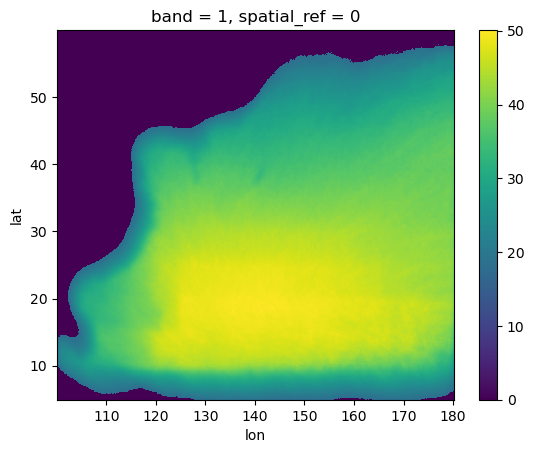

In [88]:
ds_storm.plot()

In [89]:
ds["rp_100"]

<xarray.DataArray 'rp_100' (points: 142731)> Size: 1MB
array([38.763618, 39.212308, 39.114666, ..., 24.936248, 23.958478, 23.750273])
Coordinates:
    lon      (points) float64 1MB 172.5 172.6 172.7 172.8 ... 177.5 178.5 179.5
    lat      (points) float64 1MB 52.96 52.96 52.96 52.96 ... 59.5 59.5 59.5
Dimensions without coordinates: points
Attributes:
    long_name:  Exceedance intensity for RP=100 years
    units:      m/s

In [108]:

# ─── 3) Vectorized nearest‐neighbor lookup ────────────────────────────────────
# build two DataArrays of length n_points:
lon_da = xr.DataArray(gdf["lon"].values, dims="points")
lat_da = xr.DataArray(gdf["lat"].values, dims="points")

haz_ref_da = ds_storm.sel(
    lon=lon_da,
    lat=lat_da,
    method="nearest"
)

# ─── 4) Attach back to your GeoDataFrame ──────────────────────────────────────
gdf["storm_thr_50"] = haz_ref_da.values*1.14

In [109]:
gdf.storm_thr_50.max()

56.31728744506836

In [110]:
mask_chaz = (gdf["value"] > 0) & (~gdf["value"].isna())
gdf_chaz_valid = gdf.loc[mask_chaz].copy()
print("CHAZ valid points:", len(gdf_chaz_valid))


CHAZ valid points: 74866


In [111]:
mask_storm = (gdf["storm_thr_50"] > 0) & (~gdf["storm_thr_50"].isna())
gdf_storm_valid = gdf.loc[mask_storm].copy()
print("STORM valid points:", len(gdf_storm_valid))


STORM valid points: 61055


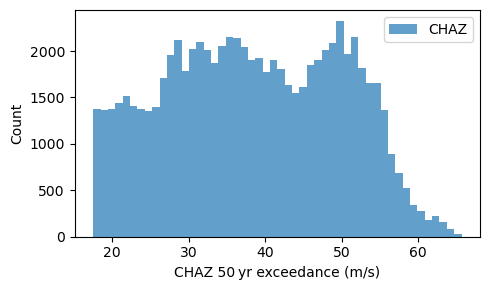

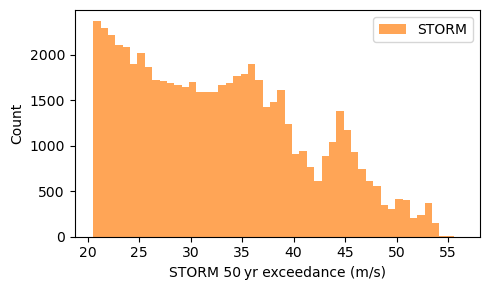

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# CHAZ
plt.figure(figsize=(5,3))
plt.hist(gdf_chaz_valid["value"], bins=50, alpha=0.7, label="CHAZ")
plt.xlabel("CHAZ 50 yr exceedance (m/s)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# STORM
plt.figure(figsize=(5,3))
plt.hist(gdf_storm_valid["storm_thr_50"], bins=50, alpha=0.7, color="C1", label="STORM")
plt.xlabel("STORM 50 yr exceedance (m/s)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


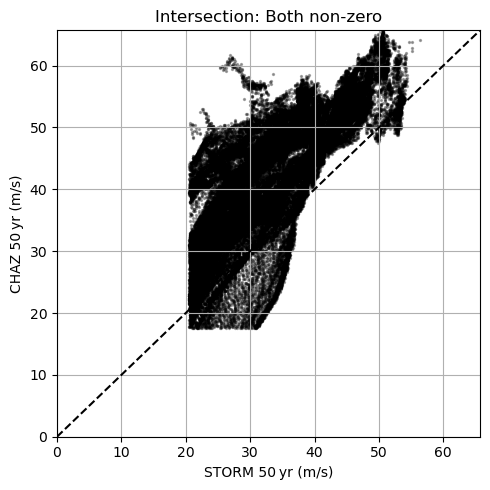

In [113]:
mask_both = mask_chaz & mask_storm
gdf_both = gdf.loc[mask_both]

plt.figure(figsize=(5,5))
plt.scatter(
    gdf_both["storm_thr_50"],
    gdf_both["value"],
    s=2, alpha=0.3, color="k"
)
lims = [0, max(gdf_both["storm_thr_50"].max(), gdf_both["value"].max())]
plt.plot(lims, lims, "k--")
plt.xlabel("STORM 50 yr (m/s)")
plt.ylabel("CHAZ 50 yr (m/s)")
plt.title("Intersection: Both non‐zero")
plt.xlim(lims); plt.ylim(lims)
plt.grid()
plt.tight_layout()
plt.show()


In [114]:
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE on CHAZ‐only points (compared to STORM where available)
# (we’ll ignore missing storm values by dropping them inside the sample)
vals_chaz = gdf_chaz_valid["value"].values
vals_ref_on_chaz = (
    gdf_chaz_valid["storm_thr_50"]
    .dropna()
    .values
)
rmse_chaz = np.sqrt(mean_squared_error(vals_chaz[:len(vals_ref_on_chaz)], 
                                        vals_ref_on_chaz))
print(f"RMSE on CHAZ-valid points: {rmse_chaz:.2f} m/s")

# RMSE on STORM‐only points
vals_storm = gdf_storm_valid["storm_thr_50"].values
vals_ref_on_storm = (
    gdf_storm_valid["value"]
    .dropna()
    .values
)
rmse_storm = np.sqrt(mean_squared_error(vals_storm[:len(vals_ref_on_storm)],
                                         vals_ref_on_storm))
print(f"RMSE on STORM-valid points: {rmse_storm:.2f} m/s")


RMSE on CHAZ-valid points: 16.26 m/s
RMSE on STORM-valid points: 11.49 m/s


Dropped 0 points with missing STORM data
Land-only RMSE at 50 yr (after dropping NaNs): 12.37 m/s


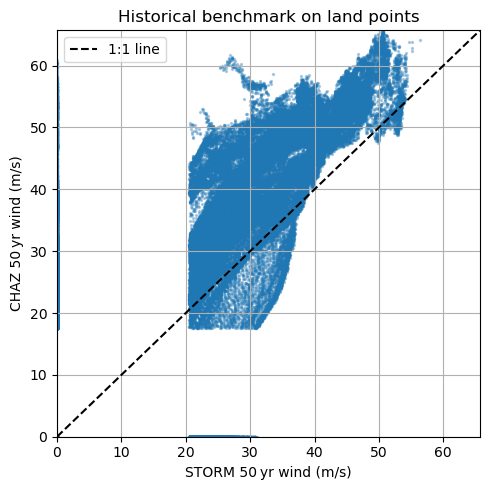

In [115]:
# ─── 2) Drop any rows with NaN in either column:
mask = (~gdf["value"].isna()) & (~gdf["storm_thr_50"].isna())
gdf_clean = gdf[mask]

print(f"Dropped {len(gdf) - len(gdf_clean)} points with missing STORM data")

# ─── 3) Compute bias & RMSE on the cleaned set:
bias = gdf_clean["value"] - gdf_clean["storm_thr_50"]
rmse = np.sqrt(mean_squared_error(
    gdf_clean["value"],
    gdf_clean["storm_thr_50"]
))
print(f"Land-only RMSE at 50 yr (after dropping NaNs): {rmse:.2f} m/s")

# ─── 4) Scatter plot on the cleaned set:
lims = [
    min(gdf_clean["storm_thr_50"].min(), gdf_clean["value"].min()),
    max(gdf_clean["storm_thr_50"].max(), gdf_clean["value"].max()),
]

plt.figure(figsize=(5,5))
plt.scatter(
    gdf_clean["storm_thr_50"],
    gdf_clean["value"],
    s=2, alpha=0.3
)
plt.plot(lims, lims, "k--", label="1:1 line")
plt.xlabel("STORM 50 yr wind (m/s)")
plt.ylabel("CHAZ 50 yr wind (m/s)")
plt.title("Historical benchmark on land points")
plt.xlim(lims); plt.ylim(lims)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


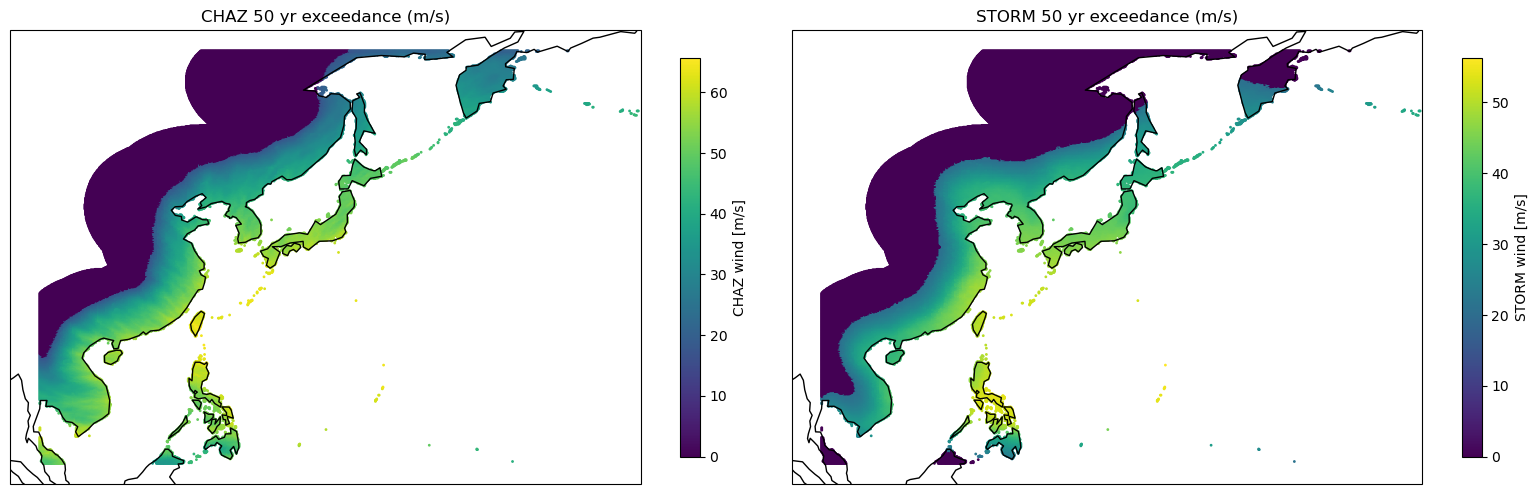

In [116]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# assume `gdf` has columns: ['lon','lat','value','storm_thr_50']

fig, axes = plt.subplots(1, 2, figsize=(16, 6),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# --- Panel 1: CHAZ 50 yr ---
sc0 = axes[0].scatter(
    gdf["lon"], gdf["lat"],
    c=gdf["value"],
    s=1,                   # small dots
    cmap="viridis",
    transform=ccrs.PlateCarree()
)
axes[0].coastlines()
axes[0].set_title("CHAZ 50 yr exceedance (m/s)")
cbar0 = fig.colorbar(sc0, ax=axes[0], shrink=0.7)
cbar0.set_label("CHAZ wind [m/s]")

# --- Panel 2: STORM 50 yr ---
sc1 = axes[1].scatter(
    gdf["lon"], gdf["lat"],
    c=gdf["storm_thr_50"],
    s=1,
    cmap="viridis",
    transform=ccrs.PlateCarree()
)
axes[1].coastlines()
axes[1].set_title("STORM 50 yr exceedance (m/s)")
cbar1 = fig.colorbar(sc1, ax=axes[1], shrink=0.7)
cbar1.set_label("STORM wind [m/s]")

plt.tight_layout()
plt.show()


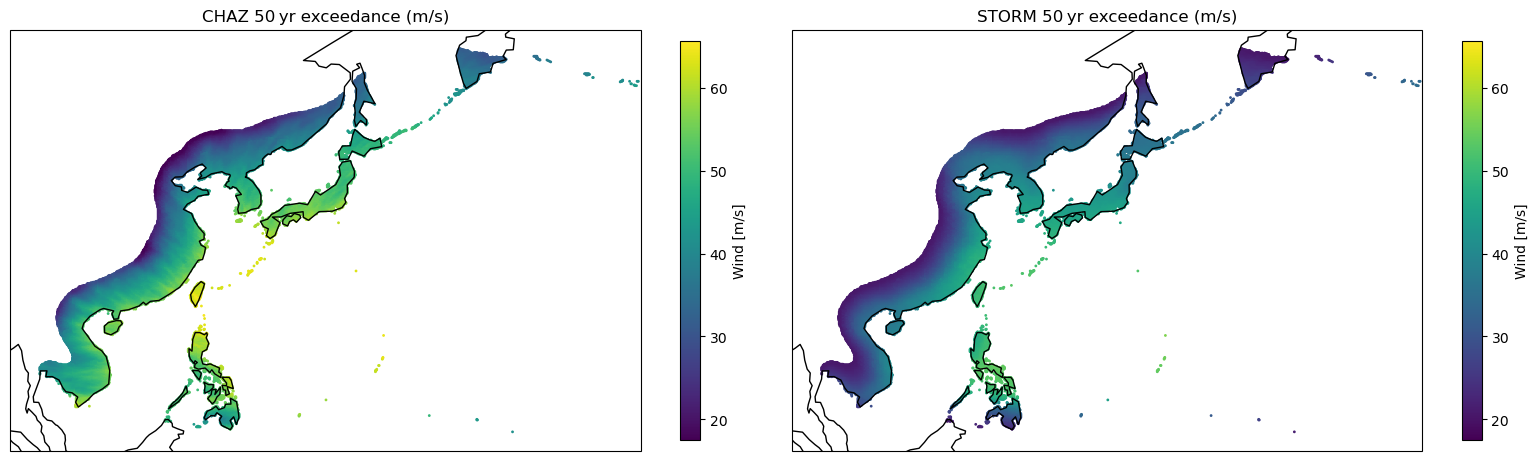

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 1) Drop zeros or NaNs
mask = (
    (gdf["value"].notna()) & (gdf["value"] > 0) &
    (gdf["storm_thr_50"].notna()) & (gdf["storm_thr_50"] > 0)
)
gdf_clean = gdf[mask]

# 2) Compute common color scale
vmin = min(gdf_clean["value"].min(), gdf_clean["storm_thr_50"].min())
vmax = max(gdf_clean["value"].max(), gdf_clean["storm_thr_50"].max())

fig, axes = plt.subplots(1, 2, figsize=(16, 6),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# Panel 1: CHAZ
sc0 = axes[0].scatter(
    gdf_clean["lon"], gdf_clean["lat"],
    c=gdf_clean["value"],
    s=1, cmap="viridis",
    vmin=vmin, vmax=vmax,
    transform=ccrs.PlateCarree()
)
axes[0].coastlines()
axes[0].set_title("CHAZ 50 yr exceedance (m/s)")
cbar0 = fig.colorbar(sc0, ax=axes[0], shrink=0.7)
cbar0.set_label("Wind [m/s]")

# Panel 2: STORM
sc1 = axes[1].scatter(
    gdf_clean["lon"], gdf_clean["lat"],
    c=gdf_clean["storm_thr_50"],
    s=1, cmap="viridis",
    vmin=vmin, vmax=vmax,
    transform=ccrs.PlateCarree()
)
axes[1].coastlines()
axes[1].set_title("STORM 50 yr exceedance (m/s)")
cbar1 = fig.colorbar(sc1, ax=axes[1], shrink=0.7)
cbar1.set_label("Wind [m/s]")

plt.tight_layout()
plt.show()


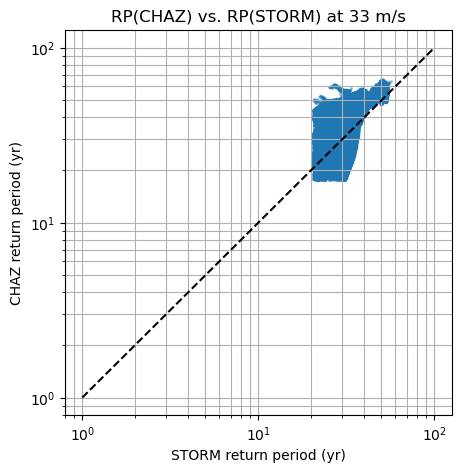

In [118]:

plt.figure(figsize=(5,5))
plt.scatter(
  gdf["storm_thr_50"],  # STORM RP at 33 m/s
  gdf["value"],  # CHAZ RP at 33 m/s
  s=2, alpha=0.3
)
plt.plot([1,100],[1,100],"k--")
plt.xlabel("STORM return period (yr)")
plt.ylabel("CHAZ return period (yr)")
plt.title("RP(CHAZ) vs. RP(STORM) at 33 m/s")
plt.xscale("log"); plt.yscale("log")
plt.grid(which="both")


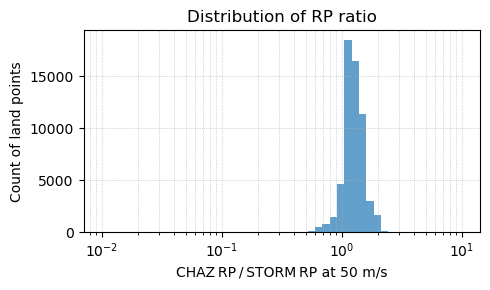

In [119]:

# 1a) ratio
gdf_clean["rp_ratio"] = gdf_clean["value"] / gdf_clean["storm_thr_50"]

# 1b) drop any infinities (just in case)
ratios = gdf_clean["rp_ratio"].replace([np.inf, -np.inf], np.nan).dropna()

# 1c) histogram on a log scale
plt.figure(figsize=(5,3))
plt.hist(ratios, bins=np.logspace(-2, 1, 50), color="C0", alpha=0.7)
plt.xscale("log")
plt.xlabel("CHAZ RP / STORM RP at 50 m/s")
plt.ylabel("Count of land points")
plt.title("Distribution of RP ratio")
plt.grid(which="both", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

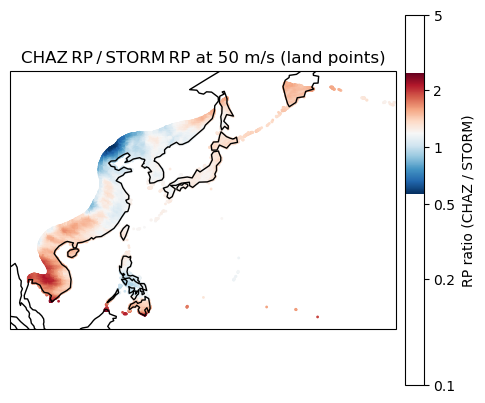

In [120]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import SymLogNorm

# 2a) set up a “symmetric log” norm so you can see both under- and over-estimation
norm = SymLogNorm(linthresh=0.2, linscale=1.0,
                  vmin=ratios.min(), vmax=ratios.max(),
                  base=10)

fig, ax = plt.subplots(1, 1, figsize=(6,8),
                       subplot_kw={"projection": ccrs.PlateCarree()})

sc = ax.scatter(
    gdf_clean["lon"], gdf_clean["lat"],
    c=gdf_clean["rp_ratio"],
    s=1,
    cmap="RdBu_r",
    norm=norm,
    transform=ccrs.PlateCarree()
)
ax.coastlines()
ax.set_title("CHAZ RP / STORM RP at 50 m/s (land points)")

# colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.02,
                    label="RP ratio (CHAZ / STORM)")
cbar.set_ticks([0.1, 0.2, 0.5, 1, 2, 5])
cbar.set_ticklabels(["0.1","0.2","0.5","1","2","5"])
plt.show()


In [123]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# 2) Select the country you want:
ph = land[land["ADMIN"] == "Philippines"]
jp = land[land["ADMIN"] == "Japan"]

# 3) Clip your gdf of land points to each country:
gdf_ph = gpd.clip(gdf, ph)
gdf_jp = gpd.clip(gdf, jp)

# 4) (Optional) report sizes
print("Points in Philippines:", len(gdf_ph))
print("Points in Japan:       ", len(gdf_jp))

# 5) Then run exactly the same diagnostics on each subset:

for country_name, subset in [("Philippines", gdf_ph), ("Japan", gdf_jp)]:
    # drop zeros/nans independently for CHAZ and STORM
    mask_chaz   = (subset["value"] > 0) & (~subset["value"].isna())
    mask_storm  = (subset["storm_thr_50"] > 0) & (~subset["storm_thr_50"].isna())
    sub_chaz    = subset.loc[mask_chaz]
    sub_storm   = subset.loc[mask_storm]
    sub_both    = subset.loc[mask_chaz & mask_storm]

    # 5a) RMSE on intersection
    rmse     = np.sqrt(mean_squared_error(
                     sub_both["value"], sub_both["storm_thr_50"]))
    print(f"{country_name} RMSE (intersection): {rmse:.2f} m/s")

    # 5b) Scatter RP(CHAZ) vs RP(STORM) at 33 m/s, log–log
    plt.figure(figsize=(4,4))
    plt.scatter(sub_both["storm_thr_33"], sub_both["value_thr_33"],
                s=5, alpha=0.5)
    plt.plot([1,1e4], [1,1e4], "k--")
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("STORM RP @33 m/s (yr)")
    plt.ylabel("CHAZ RP @33 m/s (yr)")
    plt.title(country_name)
    plt.grid(which="both", ls=":")
    plt.tight_layout()
    plt.show()

    # 5c) Histogram of CHAZ‐only and STORM‐only 50 yr exceedances
    fig, ax = plt.subplots(1,1,figsize=(4,2.5))
    ax.hist(sub_chaz["value"],  bins=30, alpha=0.6, label="CHAZ")
    ax.hist(sub_storm["storm_thr_50"], bins=30, alpha=0.6, label="STORM")
    ax.set_xlabel("50 yr wind [m/s]")
    ax.set_ylabel("Count")
    ax.set_title(country_name)
    ax.legend()
    plt.tight_layout()
    plt.show()


KeyError: 'ADMIN'

In [124]:
land

,featurecla,scalerank,min_zoom,geometry
0,Land,0.0,0.0,"MULTIPOLYGON (((-0.00029 -71.49903, 0.01555 -7..."
1,Land,6.0,5.0,"MULTIPOLYGON (((166.13697 -50.86435, 166.20525..."
2,Land,5.0,3.0,"MULTIPOLYGON (((-78.78897 -33.60906, -78.78038..."
3,Land,6.0,6.0,"MULTIPOLYGON (((163.98512 -20.04762, 163.98609..."
4,Land,5.0,4.0,"MULTIPOLYGON (((134.70737 -6.58904, 134.72006 ..."
5,Land,3.0,2.0,"MULTIPOLYGON (((-80.05989 -2.66277, -80.01452 ..."
6,Land,0.0,1.0,"MULTIPOLYGON (((81.87599 7.09195, 81.87843 7.0..."
7,None,NaN,NaN,"MULTIPOLYGON (((55.01800 24.97651, 55.01580 24..."
8,Land,1.0,1.5,"MULTIPOLYGON (((134.68979 33.82807, 134.72203 ..."
9,Land,5.0,0.5,"MULTIPOLYGON (((14.76303 68.49486, 14.71746 68..."


In [16]:
# 2) Pick out the single band and drop the band dimension
#    (if you loaded with open_rasterio it came in as DataArray with dim 'band')
ds_storm = ds_storm.sel(band=1).squeeze("band", drop=True)

# 3) Rename x→lon, y→lat so it matches your CHAZ grid conventions
ds_storm = ds_storm.rename({"x": "lon", "y": "lat"})

# 4) Make sure it knows it’s in geographic coords
ds_storm = ds_storm.rio.write_crs("EPSG:4326", inplace=True)

KeyError: 'band'

In [ ]:

# 1.3 Reproject & resample STORM onto the CHAZ grid
ds_storm_on_chaz = ds_storm.rio.reproject_match(ds_chaz)

# 1.4 Slice both datasets at the same return period (50 yr here)
rp = 50
haz_chaz = ds_chaz.sel(return_period=rp)
haz_ref  = ds_storm_on_chaz      # already only contains 50yr band

# Quick check: same dims & coords?
assert haz_chaz.shape == haz_ref.shape, "Grid shapes don’t align!"
